# This Notebook implements Latent Space Walk

# 1. Import Libraries

In [54]:
import os
if os.getcwd().split('/')[-1] == 'notebooks':
    os.chdir('../')

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.datasets as dset
from torchvision import transforms
from torch import autograd
import torch.optim as optim

from torchvision.utils import make_grid

import matplotlib.pyplot as plt

import ignite
import ignite.distributed as idist
from ignite.metrics import FID, InceptionScore

import numpy as np

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 2. Params

In [21]:
ngpu = torch.cuda.device_count() # Number of GPUs available. Use 0 for CPU mode.
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
# device = "cpu"

# 3. Load Models

In [100]:
netG = torch.load('./models/netG.pkl')
netD = torch.load('./models/netD.pkl')

# 3. Prepare Latent Space Walk

In [62]:
def calc_grasc_noise(noise, weight):
    new_noise = noise + (noise.grad*weight*1e-6)
    return new_noise

In [95]:
def show_images(image_tensor, num_images=16, size=(3, 64, 64), nrow=3):
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [69]:
num_images = 8
grad_steps = 16
skip = 2
nz = 512

In [70]:
optimizer = torch.optim.Adam(netD.parameters(), lr=0.0002)

In [71]:
noise = torch.randn(num_images, nz, 1, 1, device=device)
values = torch.linspace(0, noise.max().item(), num_images) # noise.min().item()
distant_noise = values.repeat_interleave(nz).view(num_images, nz, 1, 1).to(device).requires_grad_()

In [79]:
def interpolate_noises(p1, p2, n_steps=6):
    # interpolate ratios between the points
    ratios = np.linspace(0, 1, num=n_steps)
    # linear interpolate vectors
    vectors = list()
    vectors.append(p1)
    for ratio in ratios:
        v = (1.0 - ratio) * p1 + ratio * p2
        vectors.append(v)
    vectors.append(p2)
    return vectors

In [85]:
fake_images[0].shape

torch.Size([8, 3, 300, 300])

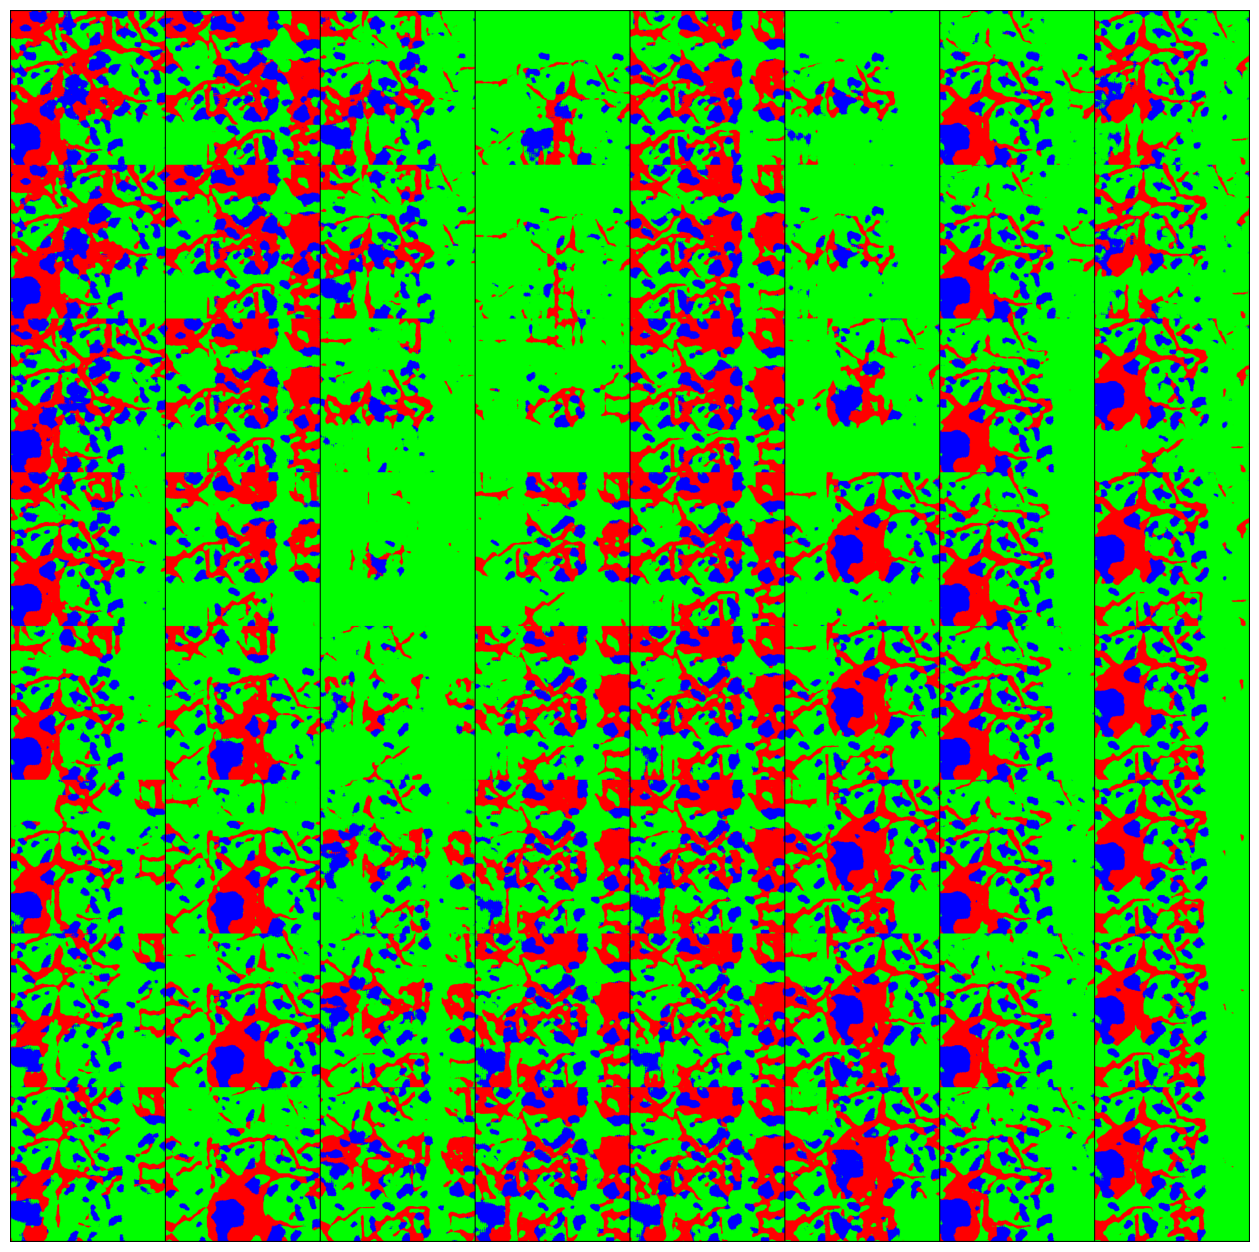

In [103]:
fake_images = []
# generate with interpolation
noise1 = torch.randn(num_images, nz, 1, 1, device=device)
noise2 = torch.randn(num_images, nz, 1, 1, device=device)
vectors = interpolate_noises(noise1, noise2)
for noise in vectors:
    fake = netG(noise)
    fake_images += [fake]
plt.rcParams['figure.figsize'] = [num_images * 2, len(vectors) * 2]
plt.axis('off')
show_images(torch.cat(fake_images, dim=2), num_images=num_images, nrow=num_images)

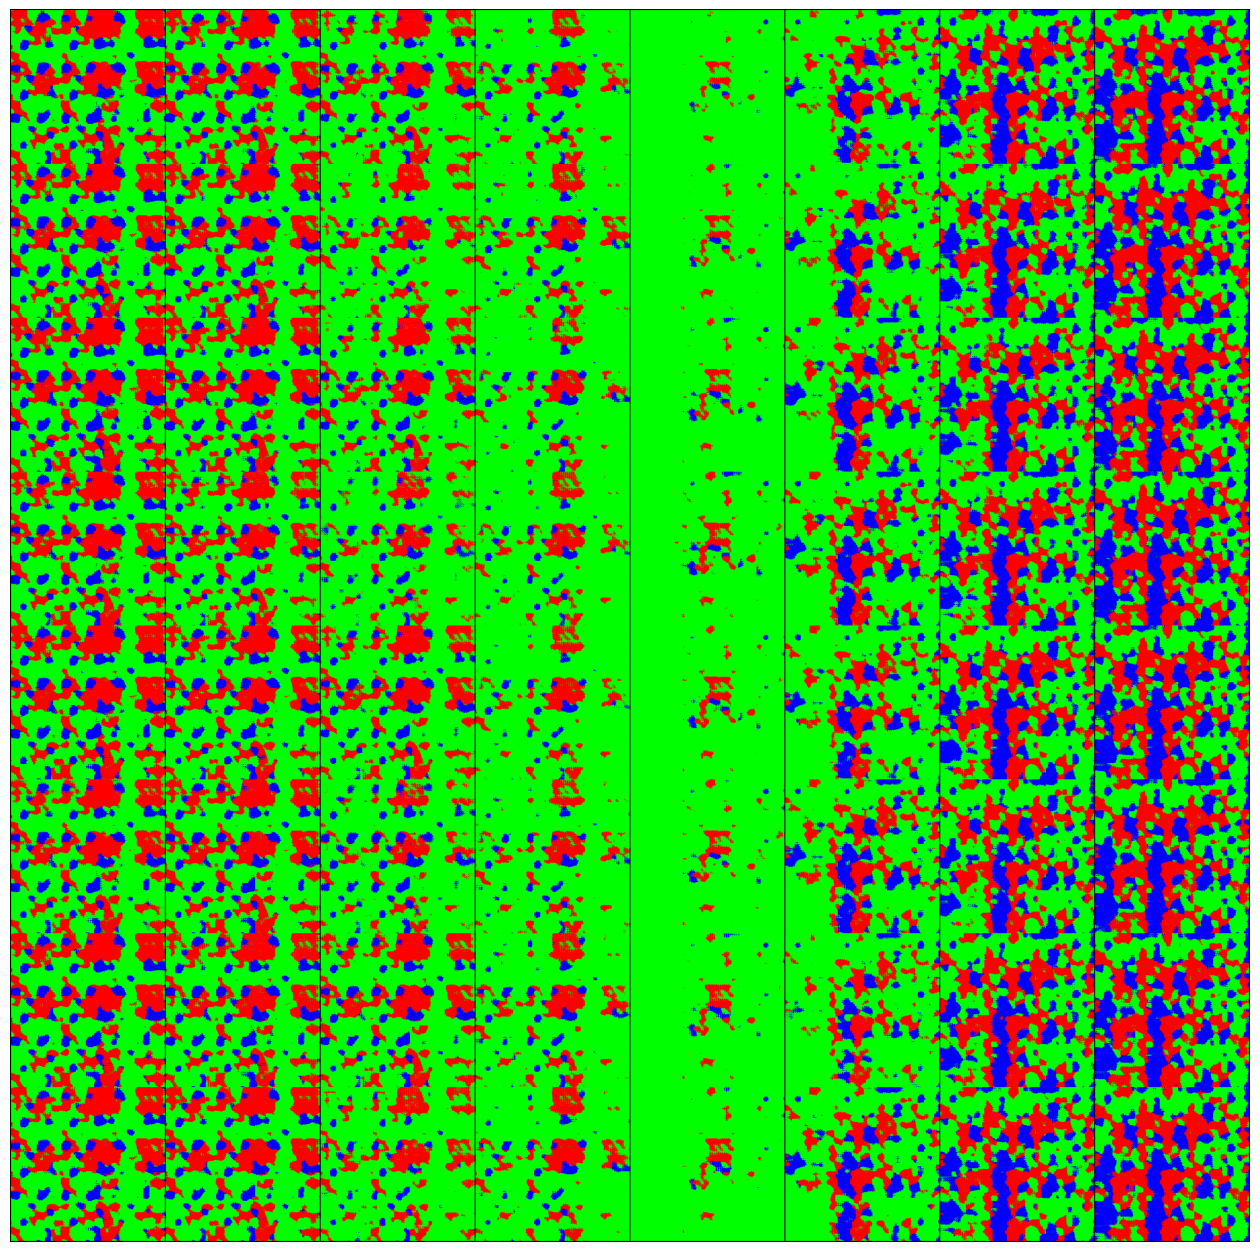

In [73]:
fake_images = []
noise = torch.randn(num_images, nz, 1, 1, device=device).requires_grad_()
for i in range(grad_steps):
    optimizer.zero_grad()
    fake = netG(distant_noise)
    fake_images += [fake]
    score = netD(fake).mean()
    score.backward()
    noise.data = calc_grasc_noise(distant_noise, 1 / grad_steps)

plt.rcParams['figure.figsize'] = [num_images * 2, grad_steps * 2]
plt.axis('off')
show_images(torch.cat(fake_images[::skip], dim=2), num_images=num_images, nrow=num_images)

In [ ]:
# example of interpolating between generated cities
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from numpy import linspace
from matplotlib import pyplot
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    return z_input
 
def interpolate_points(p1, p2, n_steps=10):
    # interpolate ratios between the points
    ratios = linspace(0, 1, num=n_steps)
    # linear interpolate vectors
    vectors = list()
    for ratio in ratios:
        v = (1.0 - ratio) * p1 + ratio * p2
        vectors.append(v)
    return asarray(vectors)
 
# create a plot of generated images
def plot_generated(examples, n):
    # plot images
    for i in range(n):
        # define subplot
        pyplot.subplot(1, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :])
        pyplot.show()

# generate points in latent space
noise = torch.randn(num_images, nz, 1, 1, device=device)
# interpolate points in latent space
interpolated = interpolate_points(pts[0], pts[1])
# generate images
X = model.predict(interpolated)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
plot_generated(X, len(interpolated))

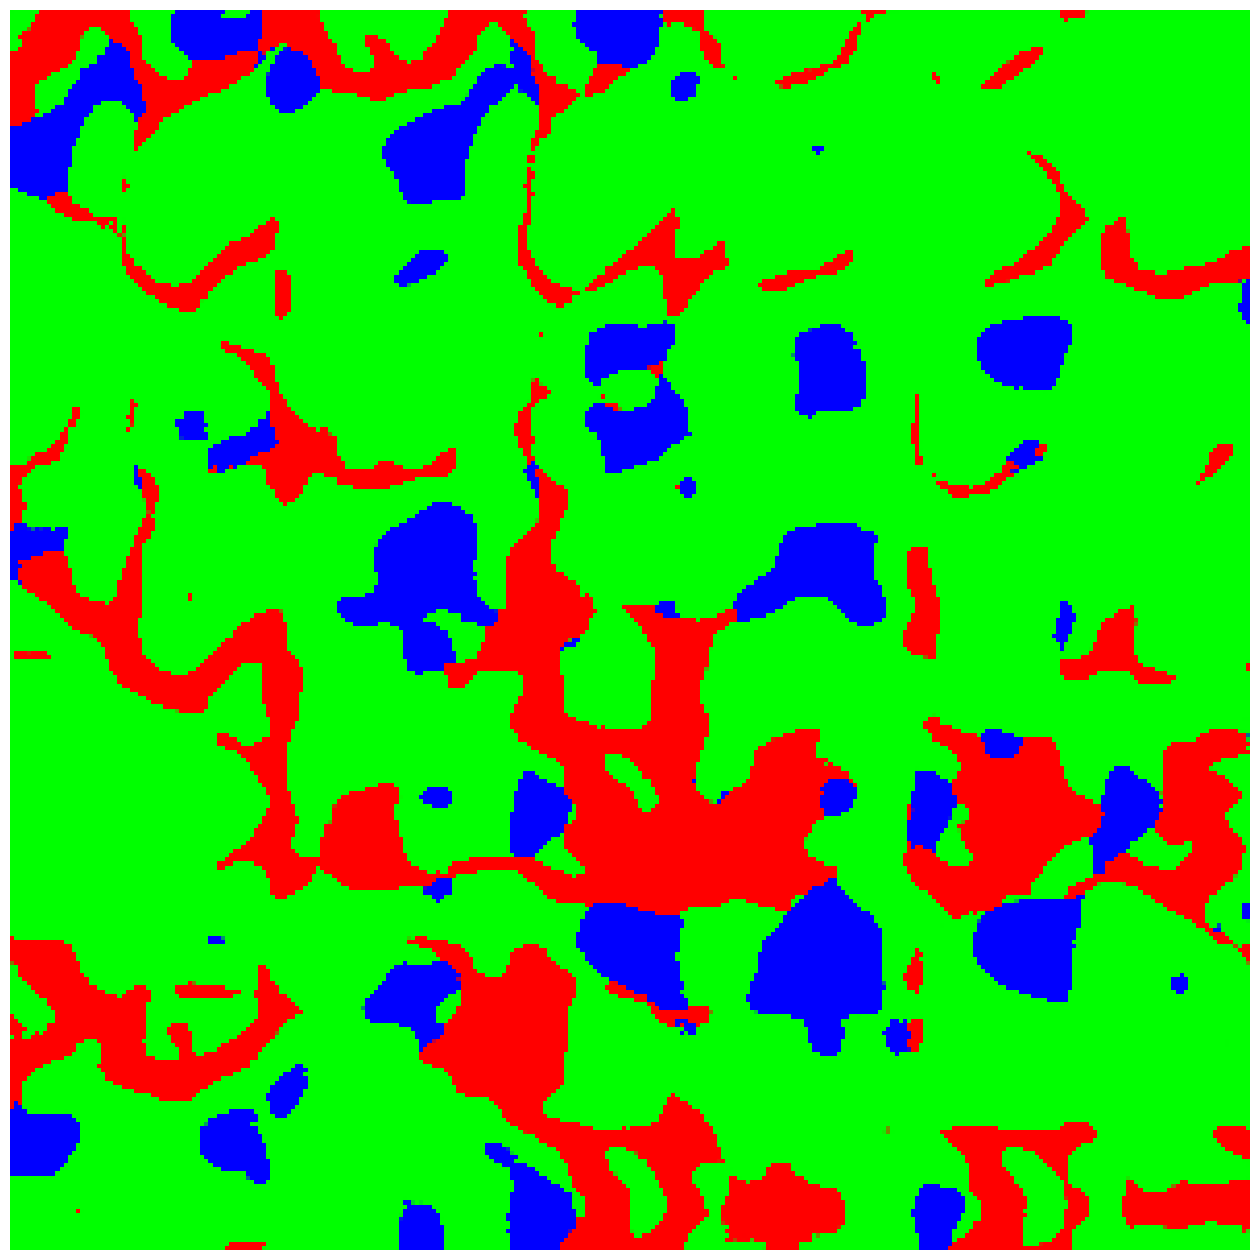

In [43]:
img = fake[2].cpu().detach()

plt.axis('off')
plt.imshow(img.permute(1,2,0), cmap='gray');